In [1]:
# standard libraries
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
from abc import ABC, abstractmethod
import time
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output
import xgboost

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# prediction models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm._base import BaseSVC 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [2]:
class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class Loader:
    df = pd.DataFrame()
    
    def load_data(self, file_name):
        pass
    
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)

In [4]:
from typing import Callable
 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path())
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [5]:
def clean_data(df):
    df['y'] = df['y'].astype(int)
    df['x32'] = df['x32'].str.replace('%','').astype(float)
    df['x37'] = df['x37'].str.replace('$','').astype(float)
#     cont_vars = df.describe().columns
#     cat_vars = set(df.columns) - set(cont_vars)
#     for column in [*cat_vars]:
#         df[column] = labelencoder.fit_transform(df[column].astype(str))
    return df

In [7]:
loader = CSVLoader(FilePathManager('final_project(5).csv'))
loader.load_data(clean_data)
df = loader.get_df()

# Model Setup

In [8]:
class BaseImputer:
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass

class BaseModel:

    def fit(self, X, y, sample_weight=None):
        pass
    
    def predict(self, X):
        pass

In [9]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None, encoder = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._encoder = encoder
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = self.X.columns
        else:
            transform_cols = cont_vars
            
        if self._scaler is not None:
            self._scaler.fit(train[transform_cols])
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = X.columns
        else:
            transform_cols = cont_vars
        scaled_data = X[transform_cols]
        if self._scaler is not None:
            scaled_data = pd.DataFrame(self._scaler.transform(X[transform_cols]), columns = transform_cols)
        X[transform_cols] = scaled_data
        return X
    
    def _encode_data(self):
        df = self.X.copy()
        cont_vars = df.describe().columns
        cat_vars = set(df.columns) - set(cont_vars)
        for column in [*cat_vars]:
            df[column] = self._encoder.fit_transform(df[column].astype(str))
        self._X = df
        return cont_vars, cat_vars
        
    
    def prepare(self):
        cont_vars = None
        if self._encoder is not None: 
            cont_vars, _ = self._encode_data()
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train, cont_vars)
        self._X_train_fitted = self._scale_data(X_train, cont_vars)
        self._X_test_fitted = self._scale_data(X_test, cont_vars)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass

In [10]:
df.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'y'],
      dtype='object')

In [11]:
class XGBModel:
    _model = None
    
    def __init__(self, params, num_round: int = 100):
        self._params = params
        self._num_round = num_round
        
    def fit(self, X, y, sample_weight=None):
        dtrain = xgb.DMatrix(X, label = y)
        self._model = xgb.train(self._params, dtrain)
        
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self._model.predict(dtest)

In [12]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None,
                 encoder = None,
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder)
        self.beta = beta
        self.classification = classification
        
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass

In [13]:
from typing import Type, TypeVar

class XGBClassificationModeling(ClassificationModeling):
    TXGB = TypeVar("TXGB", bound=XGBClassifier)
    all_models = [];
    
    def __init__(self, 
             data: pd.DataFrame, 
             target_name: str, 
             shuffle_splitter: BaseShuffleSplit, 
             imputer: BaseImputer, 
             model: BaseModel, 
             scaler = None,
             encoder = None,
             beta: int = 1, 
             classification: str = 'binary'):
         super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder, beta, classification)
        
            
    def parameter_tuning(self, params, class_to_instantiate: Type[TXGB]):
        list_of_models = []
        combination = []
        params_base = {}
        output = []
        for key, value in params.items():
            if isinstance(value, list):
                combination.append((key,value))
            else:
                params_base[key]=value
              
        result = XGBClassificationModeling.get_combinations(combination)

        for r in result:
            list_of_models.append(class_to_instantiate(**{**params_base, **r}))
            
        for a_model in list_of_models:
            self.model = a_model
            startTrain = time.time()
            train_metrics = self.train()
            endTrain = time.time()
            test_metrics = self.test()
            endTest = time.time()
            train_time = endTrain - startTrain
            test_time = endTest - endTrain
            output.append({'model': a_model, 'train_metrics': {**train_metrics,**{'elapsed_time':train_time}}, 'test_metrics': {**test_metrics,**{'elapsed_time':test_time}}})
        self.all_models = output
        return output
        
    def find_best_model(self):
        max_accuracy = self.all_models[0]['test_metrics']['accuracy']
        location = 0
        for indx, output_metrics in enumerate(self.all_models):
            if max_accuracy < output_metrics['test_metrics']['accuracy']:
                max_accuracy = output_metrics['test_metrics']['accuracy']
                location = indx
            elif max_accuracy == output_metrics['test_metrics']['accuracy']:
                if output_metrics['test_metrics']['elapsed_time'] < self.all_models[location]['test_metrics']['elapsed_time']:
                    location = indx
                
        return self.all_models[location]
    
    @staticmethod
    def get_combinations(tuples):
        length = len(tuples)
        if length > 1:
            total_params = []
            tuple_copy = tuples.copy()
            a_tuple = tuple_copy.pop(0)
            params_list = XGBClassificationModeling.get_combinations(tuple_copy)
            for value in a_tuple[1]:
                for a_params in params_list:
                    temp = { a_tuple[0]: value}
                    total_params.append({**temp, **a_params})
            return total_params
        else:
            params_list = []
            a_tuple =  tuples[0]
            for value in a_tuple[1]:
                temp = {}
                temp[a_tuple[0]] = value
                params_list.append(temp)
            return params_list
            
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds       
        return {'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': round(accuracy_score(y_true, y_pred), 5), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                'f1': f1_score(y_true, y_pred)}

In [14]:
xgb_classifier = XGBClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           None, XGBClassifier, None, LabelEncoder(), beta=1)

In [15]:
xgb_classifier.prepare()

In [16]:
xgb_classifier.X['x24']

0         2
1         1
2         1
3         1
4         1
         ..
159995    1
159996    1
159997    1
159998    1
159999    1
Name: x24, Length: 160000, dtype: int64

In [20]:
xgb_results = xgb_classifier.parameter_tuning( { 
    'max_depth': [3],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'colsample_bytree': [0.3],
 }, XGBClassifier)

[18:17:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
xgb_results

[{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.3,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                subsample=1, tree_method='exact', validate_parameters=1,
                verbosity=None),
  'train_metrics': {'matrix': array([[60663,  6399],
          [12781, 32157]]),
   'accuracy': 0.82875,
   'precision': 0.8340336134453782,
   'recall': 0.7155859183764297,
   'f1': 0.7702828945792514,
   'elapsed_time': 7.661539077758789},
  'test_metrics': {'matrix': array([[25890,  2851],
          [ 5630, 13629]]),
  

In [21]:
final_model = xgb_results[0]

In [19]:
xgb_results = xgb_classifier.parameter_tuning( { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
 }, XGBClassifier)

[18:16:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [24]:
final_model

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.3,
               enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               subsample=1, tree_method='exact', validate_parameters=1,
               verbosity=None),
 'train_metrics': {'matrix': array([[60663,  6399],
         [12781, 32157]]),
  'accuracy': 0.82875,
  'precision': 0.8340336134453782,
  'recall': 0.7155859183764297,
  'f1': 0.7702828945792514,
  'elapsed_time': 7.226953029632568},
 'test_metrics': {'matrix': array([[25890,  2851],
         [ 5630, 13629]]),
  'accuracy': 0.82331

XGB Classifier

In [22]:
# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn
# For data manipulation
import pandas as pd
import numpy as np

In [ ]:
# Initialize the model and set the hyperparameter values
#model = XGBClassifier(max_depth=2, n_estimators=30, eval_metric='mlogloss')
#model

In [33]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5)
# Perform K-Fold Cross Validation
results = cross_val_score(final_model['model'], xgb_classifier.X_train, xgb_classifier.y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[18:23:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:13] WARNING: /Users/runner/miniforge3/cond

In [34]:
model.fit(xgb_classifier.X_train, xgb_classifier.y_train)

NameError: name 'model' is not defined

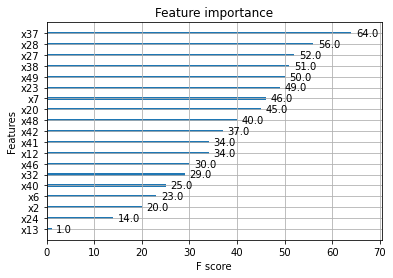

In [41]:
import xgboost
# Plot the top 7 features
xgboost.plot_importance(final_model['model'], max_num_features=20)
# Show the plot
plt.show()

In [36]:
# Predict the trading signal on test dataset
y_pred = final_model['model'].predict(xgb_classifier.X_test)
# Get the classification report
print(classification_report(xgb_classifier.y_test, xgb_classifier.y_pred))

AttributeError: 'XGBClassificationModeling' object has no attribute 'y_pred'

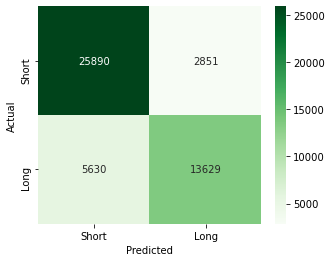

In [39]:
array = confusion_matrix(xgb_classifier.y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()